# Import Module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from tqdm.notebook import tqdm
import talib
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from yahoofinancials import YahooFinancials
import pandas_datareader as web
%matplotlib inline

# Environment

In [2]:
class SingleStock:
    '''
    Single Stock for trading 

    '''
    def __init__(self, data, capital):
        self.stock_price_history = data
        self.n_step = self.stock_price_history.shape[0]
        self.capital = capital
        self.current_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        self.state_dim = 8  # [stock price, stock_owned, cash_in_hand, rsi, mom, adx, macd, macd_sig]
        self.save_position = []
        self.save_port_val = []
        self.save_cash = []
        self.stock_value = []
        self.action_space = list(range(-500, 600, 100))
        self.sell_buy = None
        self.save_stock_price = []
        self.rsi = None
        self.mom = None
        self.adx = None
        self.macd = None
        self.masc_sig = None
        self.save_reward = None
        self.reset()

    def state_vector(self):
        vector = np.empty(self.state_dim)
        vector[0] = self.stock_price
        vector[1] = self.stock_owned
        vector[2] = self.cash_in_hand
        vector[3] = self.rsi
        vector[4] = self.mom
        vector[5] = self.adx
        vector[6] = self.macd
        vector[7] = self.masc_sig
        return vector

    
    def reset(self):
        self.current_step = 0
        self.stock_owned = 0
        self.stock_price = self.stock_price_history['Adj Close'][self.current_step]
        self.cash_in_hand = self.capital
        self.save_position = [0]
        self.save_port_val = [self.capital]
        self.save_cash = [self.capital]
        self.stock_value = [0]
        self.sell_buy = ['hold']
        self.save_stock_price = [self.stock_price]
        self.rsi = self.stock_price_history['rsi'][self.current_step]
        self.mom = self.stock_price_history['mom'][self.current_step]
        self.adx = self.stock_price_history['adx'][self.current_step]
        self.macd = self.stock_price_history['macd'][self.current_step]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_step]
        self.save_reward = [0]
        return self.state_vector()

    def port_val(self):
        return (self.stock_owned * self.stock_price) + self.cash_in_hand

    def trade(self, action):

        assert action in range(len(self.action_space))

        position = self.action_space[action]
        
        
        if position > 0:
            #buy
            if self.cash_in_hand >= (position * self.stock_price):
                self.cash_in_hand -= (position * self.stock_price)
                self.stock_owned += position
                self.sell_buy.append('buy')
                
            else:
                self.sell_buy.append('hold')
                
        elif position < 0:
            #sell
            if self.stock_owned >= abs(position):
                self.stock_owned -= abs(position)
                self.cash_in_hand += abs(position * self.stock_price)
                self.sell_buy.append('sell')
                
            else:
                self.sell_buy.append('hold')
                
        else:
            self.sell_buy.append('hold')

                
        self.save_cash.append(self.cash_in_hand)
        self.save_port_val.append(self.port_val())
        self.save_position.append(self.stock_owned)
        self.stock_value.append(self.stock_owned * self.stock_price)
        self.save_stock_price.append(self.stock_price)

    def step(self, action):
        assert action in range(len(self.action_space))

        prev_val = self.port_val()
        self.current_step += 1
        self.stock_price = self.stock_price_history['Adj Close'][self.current_step]
        self.rsi = self.stock_price_history['rsi'][self.current_step]
        self.mom = self.stock_price_history['mom'][self.current_step]
        self.adx = self.stock_price_history['adx'][self.current_step]
        self.macd = self.stock_price_history['macd'][self.current_step]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_step]
        self.trade(action)
        current_val = self.port_val()
        reward = self.port_val()
        self.save_reward.append(reward)
        done = self.current_step == self.n_step - 1
        info = {'stock_price': self.save_stock_price,
                'portfolio_value': self.save_port_val,
                'current_val': self.save_reward,
                'stock_owned': self.save_position,
                'cash_in_hand': self.save_cash,
                'stock_value': self.stock_value,
                'sell_buy': self.sell_buy
                }
        return self.state_vector(), reward, done, info

# Scaler

In [3]:
def get_scaler(env):
    states = []
    for i in range(env.n_step):
        action = np.random.choice(range(len(env.action_space)))
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

# Neural Network

In [4]:
class NeuralNetwork(nn.Module):
    '''
    Network for predict action trading 
    '''
    
    def __init__(self, input_sz, action_sz):
        super().__init__()
        self.input_sz = input_sz
        self.action_sz = action_sz
        self.fc1 = nn.Linear(input_sz, 30)
        self.fc2 = nn.Linear(30, 40)
        self.out = nn.Linear(40, action_sz)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        q_values = F.relu(self.out(x))
        return q_values
    


# Memory

In [5]:
class ExperienceReplayMemory:
    '''
    Memory storage for experience replay
    '''
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        
    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]
            
    def sample(self, batch_size):
        '''Sample event from memory (len = batch size)'''
        # [batch_state, batch_next_state, batch_action, batch_reward]
        samples = zip(*random.sample(self.memory, batch_size))
        return map(lambda x: Variable(torch.cat(x, 0)), samples)
    


# Agent

In [6]:
class DQNAgent:
    '''Agent'''
    def __init__(self, input_sz, action_sz, discount_factor):
        self.model = NeuralNetwork(input_sz, action_sz)
        self.memory = ExperienceReplayMemory(capacity=10000)
        self.discount_factor = discount_factor
        self.reward_window = []
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.last_state = torch.Tensor(input_sz).unsqueeze(0) #shape [1, 5]
        self.last_action = 0
        self.last_raward = 0
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 256
        self.action_sz = action_sz
        self.criterion = nn.MSELoss()
        self.losses = []
        
    
    def get_action(self, state):
        '''
        Epsilon-greedy selection
        '''
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_sz)
        
        q_values_probs = F.softmax(self.model(state.clone().detach()) * 10, dim=0)
        action = q_values_probs.multinomial(num_samples=1)
        return action.data[0, 0]
    
    
    def train(self, batch_state, batch_next_state, batch_action, batch_reward):
        outputs = self.model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1) #Q(s,a)
        #output = outputs.gather(1, batch_action.unsqueeze(1)).squeeze(1) #Q(s,a)
        next_outputs = self.model(batch_next_state).detach().max(1)[0] #Q(s',a')
        target = batch_reward + self.discount_factor * next_outputs #target = reward + gamma*Q(s',a')
        loss = F.smooth_l1_loss(outputs, target)
        self.losses.append(loss.item()) #loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
    def update(self, reward, new_state):
        new_state = torch.tensor(new_state[0]).float().unsqueeze(0)
        self.memory.push((self.last_state,
                        new_state,
                        torch.LongTensor([int(self.last_action)]),
                        torch.Tensor([self.last_raward])))
        action = self.get_action(new_state)
        if len(self.memory.memory) > self.batch_size:
            #sample batch event from memory (experience replay)
            batch_state, batch_next_state, batch_action, batch_reward = self.memory.sample(self.batch_size)
            #learn
            self.train(batch_state, batch_next_state, batch_action, batch_reward)
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        self.last_action = action
        self.last_state = new_state
        self.last_raward = reward
        self.reward_window.append(reward)
        if len(self.reward_window) > self.batch_size:
            del self.reward_window[0]
        return action
    

    def score(self):
        return sum(self.reward_window) / (len(self.reward_window) + 1.)
    
    def save(self):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer': self.optimizer.state_dict(),
                    }, 'trading010.pth')
        print('=> Saved!!!...')
        

    def load(self):
        if os.path.isfile('trading010.pth'):
            print("==> loading parameters!")
            checkpoint = torch.load('trading010.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.model.eval()
            print("done !")
        else:
            print("no parameters found...")
        
   
        

# Play one episode

In [7]:
def play_one_episode(agent, env, scaler):
    last_state = env.reset()
    last_reward = 0
    done = False
    scores = []
    while not done:
        last_state = scaler.transform([last_state])
        action = agent.update(last_reward, last_state)
        scores.append(agent.score())
        last_state, last_reward, done, info = env.step(action)
        
    
    return info, scores

# Stock data

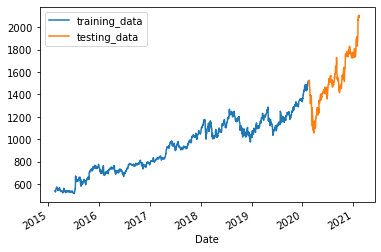

In [8]:
# stock_name = 'aapl'
# stock_data = yf.download(stock_name, period='60d', interval='5m');
# stock_data['Volume'] = stock_data['Volume'].apply(lambda vol: np.NaN if vol == 0 else vol)
# stock_data.dropna(axis=0, inplace=True)
stock_data = web.DataReader('goog', 'yahoo', '2015-01-01', '2026-01-01')
stock_data['rsi'] = talib.RSI(stock_data['Adj Close'])
stock_data['mom'] = talib.MOM(stock_data['Adj Close'])
stock_data['adx'] = talib.ADX(stock_data['High'], stock_data['Low'], stock_data['Adj Close'])
stock_data['macd'], stock_data['macd sig'], _ = talib.MACD(stock_data['Adj Close'])
stock_data.dropna(axis=0, inplace=True)

train_data = stock_data.iloc[:-253]
test_data = stock_data.iloc[-253:]

train_data['Adj Close'].plot(label='training_data')
test_data['Adj Close'].plot(label='testing_data')
plt.legend()

# Training model

In [9]:
num_episodes = 100
capital = 100000
env = SingleStock(train_data, capital)
state_size = env.state_dim
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size, 0.9)
scaler = get_scaler(env)

  0%|          | 0/100 [00:00<?, ?it/s]

episode: 1/100, episode end value: 151067.94
episode: 2/100, episode end value: 131743.80
episode: 3/100, episode end value: 169990.13
episode: 4/100, episode end value: 102310.07
episode: 5/100, episode end value: 163994.46
episode: 6/100, episode end value: 157103.04
episode: 7/100, episode end value: 130028.83
episode: 8/100, episode end value: 133319.48
episode: 9/100, episode end value: 102950.26
episode: 10/100, episode end value: 172790.73
episode: 11/100, episode end value: 175376.73
episode: 12/100, episode end value: 173858.65
episode: 13/100, episode end value: 157108.51
episode: 14/100, episode end value: 162889.82
episode: 15/100, episode end value: 132407.89
episode: 16/100, episode end value: 144805.20
episode: 17/100, episode end value: 178402.74
episode: 18/100, episode end value: 111084.58
episode: 19/100, episode end value: 135246.09
episode: 20/100, episode end value: 106544.18
episode: 21/100, episode end value: 110851.13
episode: 22/100, episode end value: 97881.8

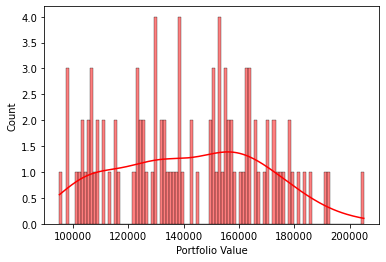

In [11]:
#train

portfolio_value = []
for e in tqdm(range(num_episodes)):

    val, scores = play_one_episode(agent, env, scaler)

    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val['portfolio_value'][-1]:.2f}")
    portfolio_value.append(val['portfolio_value'][-1]) 
    
agent.save()
losses = agent.losses

print(f'average reward: {np.mean(portfolio_value):.2f}, min: {np.min(portfolio_value):.2f}, max: {np.max(portfolio_value):.2f}')
sns.histplot(portfolio_value, bins=100, color='r', kde=True);
plt.xlabel('Portfolio Value');
plt.ylabel('Count');

<AxesSubplot:>

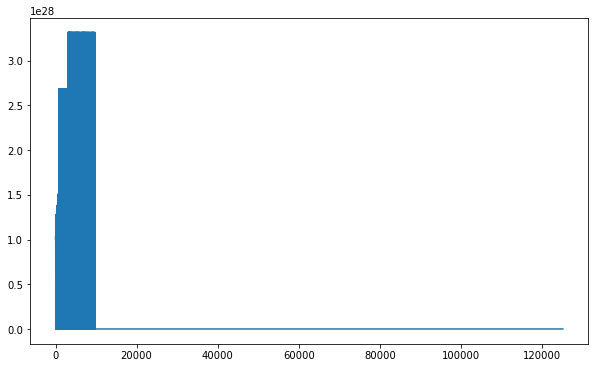

In [12]:
pd.Series(losses).plot(figsize=(10,6))

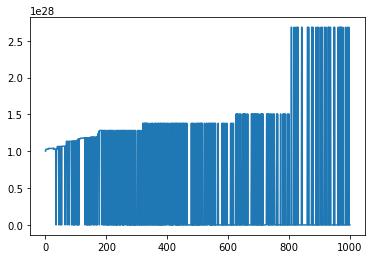

In [14]:
plt.plot(range(len(losses[:1000])), losses[:1000])

<AxesSubplot:>

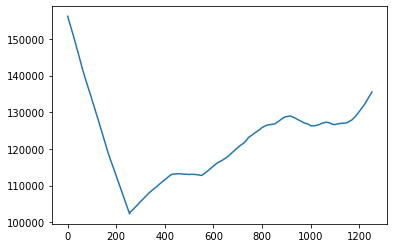

In [15]:
pd.Series(scores).plot()

# Testing Model

In [16]:

env = SingleStock(test_data, capital)
state_size = env.state_dim
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size,0.9)

last_state = env.reset()
last_reward = 0
done = False
scores = []
agent.load()

while not done:
    last_state = scaler.transform([last_state])
    last_state = torch.Tensor(last_state[0]).float().unsqueeze(0)
    with torch.no_grad():
        action = agent.model(last_state).argmax().item()
    last_state, last_reward, done, info = env.step(action)



print(f"Portfolio Value: {info['portfolio_value'][-1]}")
print(f"Sell: {env.sell_buy.count('sell')} times, Buy: {env.sell_buy.count('buy')} times")

==> loading parameters!
done !
Portfolio Value: 100000.0
Sell: 0 times, Buy: 0 times


In [17]:
result = pd.DataFrame(info)
result.index = test_data.index

In [18]:
def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan

In [19]:
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1)
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1)

In [20]:
result

,stock_price,portfolio_value,current_val,stock_owned,cash_in_hand,stock_value,sell_buy,marker_buy,marker_sell
Date,,,,,,,,,
2020-02-13,1514.660034,100000.0,0.0,0,100000,0.0,hold,NaN,NaN
2020-02-14,1520.739990,100000.0,100000.0,0,100000,0.0,hold,NaN,NaN
2020-02-18,1519.670044,100000.0,100000.0,0,100000,0.0,hold,NaN,NaN
2020-02-19,1526.689941,100000.0,100000.0,0,100000,0.0,hold,NaN,NaN
2020-02-20,1518.150024,100000.0,100000.0,0,100000,0.0,hold,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-02-08,2092.909912,100000.0,100000.0,0,100000,0.0,hold,NaN,NaN
2021-02-09,2083.510010,100000.0,100000.0,0,100000,0.0,hold,NaN,NaN
2021-02-10,2095.379883,100000.0,100000.0,0,100000,0.0,hold,NaN,NaN


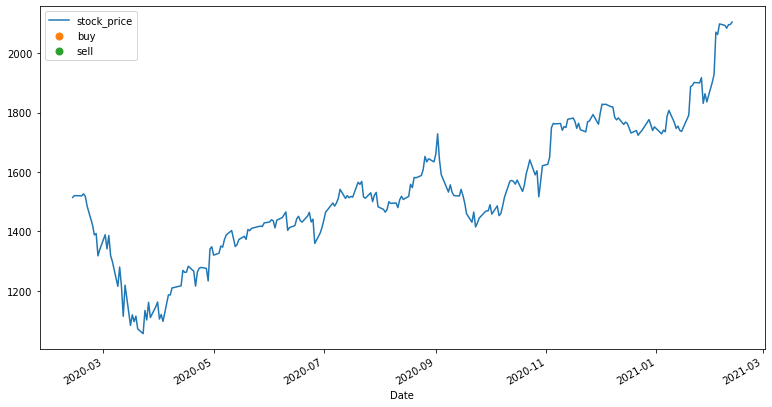

In [21]:
result['stock_price'].plot(figsize=(13,7))
result['marker_buy'].plot(style='o', ms=7, label='buy')
result['marker_sell'].plot(style='o', ms=7, label='sell')
plt.legend()

<AxesSubplot:xlabel='Date'>

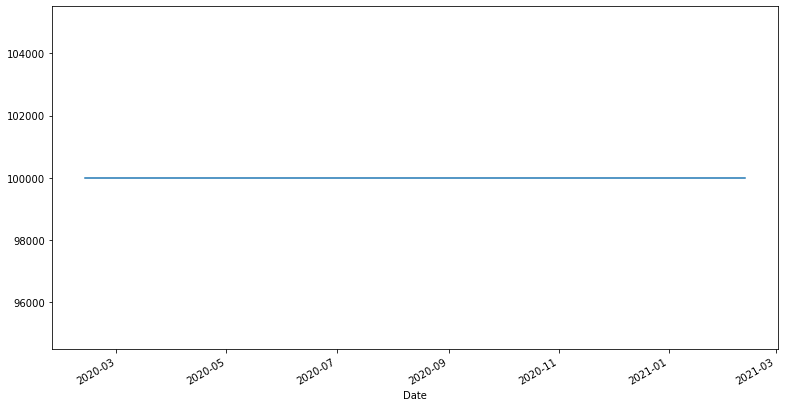

In [22]:
result['portfolio_value'].plot(figsize=(13,7))

<AxesSubplot:xlabel='Date'>

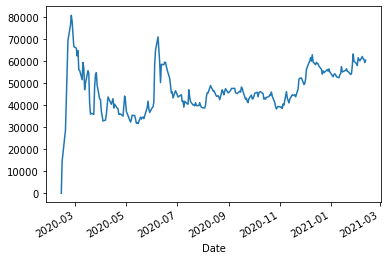

In [21]:
result['stock_value'].plot()

<AxesSubplot:xlabel='Date'>

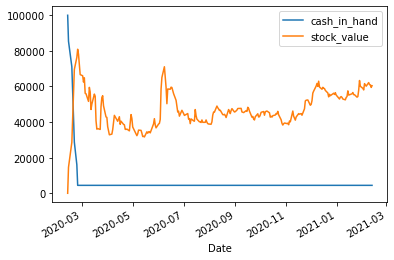

In [22]:
result[['cash_in_hand', 'stock_value']].plot()

# Performance Measurement

In [37]:
import numpy as np
import datetime as dt


bn = test_data


def CAGR(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    n = len(df)/21168
    cagr = (df['cumulative_ret'][-1])**(1/n) - 1
    return cagr

def volatility(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    vol = df['daily_ret'].std() * np.sqrt(21168)
    return vol


def sharpe(DF, rf):
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    df['cum_roll_max'] = df['cumulative_ret'].cummax()
    df['drawdown'] = df['cum_roll_max'] - df['cumulative_ret']
    df['drawdown_pct'] = df['drawdown']/df['cum_roll_max']
    max_dd = df['drawdown_pct'].max()
    return max_dd

def calmer(DF):
    df = DF.copy()
    clmr = CAGR(df)/max_dd(df)
    return clmr


In [38]:
print(f'Stock name: {stock_name}')
print(f'Start: {result.index[0]}  End: {result.index[-1]}')
print(f'Compound Annual Growth Rate: {CAGR(result):.4f}')
print(f'Volatility: {volatility(result):.4f}')
print(f'shape ratio: {sharpe(result, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(result):.4f}')
print(f'Calmar ratio: {calmer(result):.4f}')
print()
print('Comparing with Benchmark')
print(f'Compound Annual Growth Rate (benchmark): {CAGR(bn):.4f}')
print(f'Volatility (benchmark): {volatility(bn):.4f}')
print(f'shape ratio: {sharpe(bn, 0.011):.4f}')
print(f'Calmar ratio (benchmark): {calmer(bn):.4f}')

Stock name: gold
Start: 2020-12-28 13:40:00-05:00  End: 2021-02-09 15:55:00-05:00
Compound Annual Growth Rate: -0.2016
Volatility: 0.3695
shape ratio: -0.5754
Maximun drawdown: 0.1256
Calmar ratio: -1.6047

Comparing with Benchmark
Compound Annual Growth Rate (benchmark): -0.2104
Volatility (benchmark): 0.3695
shape ratio: -0.5992
Calmar ratio (benchmark): -1.6749


In [49]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')